# Antarctica Sea Surface Temperature

## Creating the Model Grid

First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import netCDF4 as nc4

## My Model

The grid for my model will be located on the coast of Antarctica covering 30-90$^{\circ}$W in longitude and 50-80$^{\circ}$S in latitude. The grid spacing will be $1/6^{\circ}$ in the zonal (east-west) direction and $1/12^{\circ}$ in the meridional (north-south) direction, covering a grid of 360 rows and 360 columns. 

In the data file for my model, I will specifiy the following parameters in the `PARM04` namelist in the `data` file:

```
usingSphericalPolarGrid=.TRUE.,
delX=360*0.166667,
delY=360*0.0.083333,
xgOrigin=-90,
ygOrigin=-80,
```

This grid can be recreated in Python as follows:

In [2]:
# define the parameters that will be used in the data file
delX = 1/6
delY = 1/12
xgOrigin = -90
ygOrigin = -80
n_rows = 360
n_cols = 360

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

### Visualizing the Grid
The grids above can be visualized as follows:

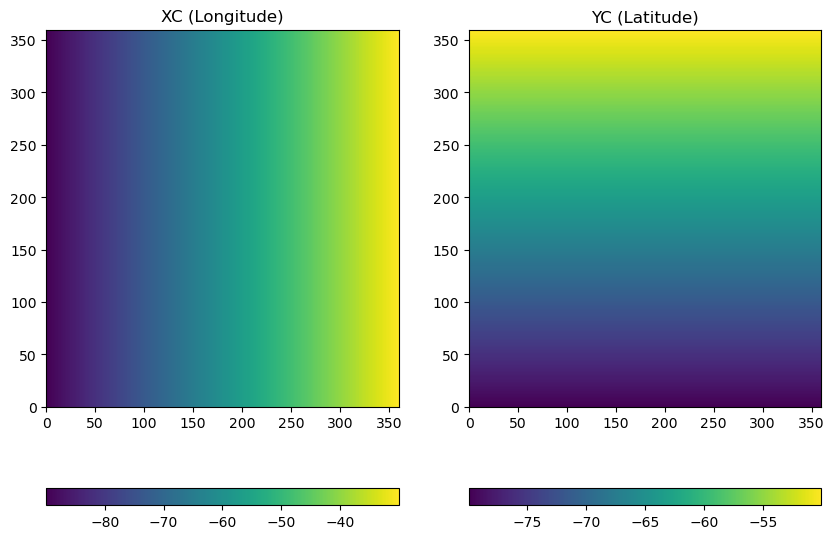

In [3]:
# make a plot of XC and YC
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('XC (Longitude)')

plt.subplot(1,2,2)
C = plt.pcolormesh(YC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC (Latitude)')

plt.show()

### Visualizing the Grid on a Map with Cartopy
To get a sense of where the model is located on the globe, cartopy can be be used to plot the domain on the globe:

/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:712: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.interse

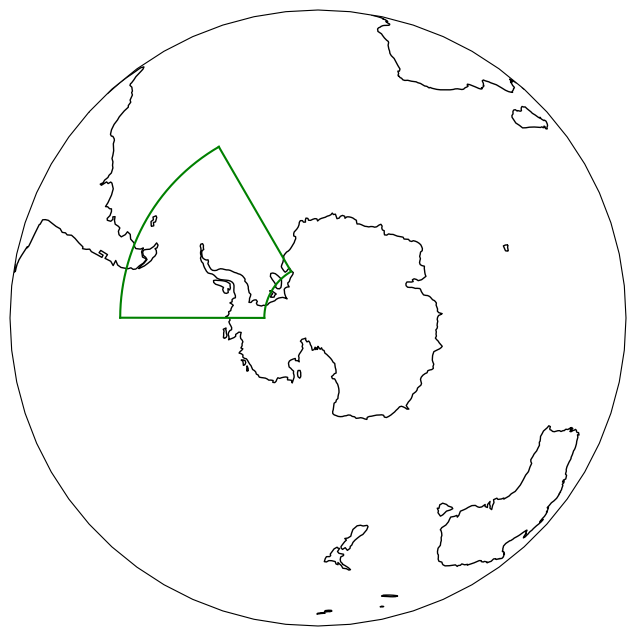

In [4]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Orthographic(0, -90))
ax.plot(XC[:,0], YC[:,0], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[:,-1], YC[:,-1], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[0,:], YC[0,:], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[-1,:], YC[-1,:], 'g-', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.show()

### Visualizing the Grid Spacing
The model grid is defined in terms of units in longitude and latitude although it is useful to quantify the grid spacing in terms of more familiar units, such as meters. The following `great_circle_distance` function can be used to quantify this distance:

In [5]:
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

Then, loop through the points to generate inter-point distances in the horizontal (`dXC`) and vertical (`dYC`) directions:

In [6]:
dXC = np.zeros((np.shape(XC)[0], np.shape(XC)[1]-1))
for row in range(np.shape(XC)[0]):
    for col in range(np.shape(XC)[1]-1):
        dXC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row,col+1], YC[row,col+1])

dYC = np.zeros((np.shape(YC)[0]-1, np.shape(YC)[1]))
for row in range(np.shape(XC)[0]-1):
    for col in range(np.shape(XC)[1]):
        dYC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row+1,col], YC[row+1,col])

Finally, make a plot of the inter-point distances:

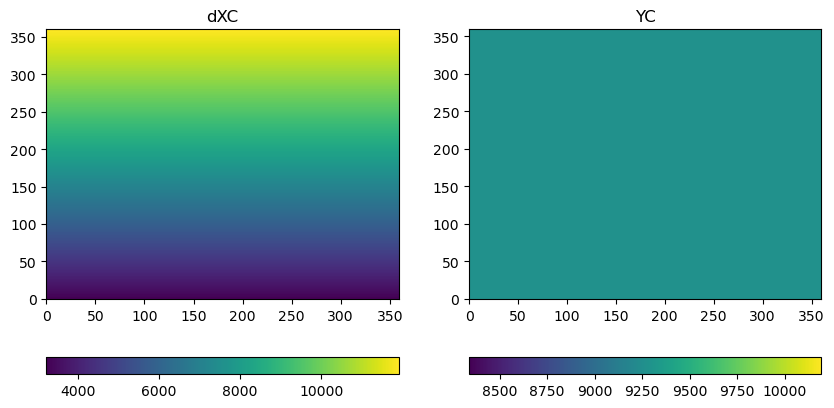

In [7]:
# make a plot of XC and YC
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(dXC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('dXC')

plt.subplot(1,2,2)
C = plt.pcolormesh(dYC.round(3))
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC')

plt.show()

As we can see the grid has a resolution of about 7 km, although there is a north-south gradient in horizontal distances (in other words, points further north are closer together). 

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For my model, I requested a subset covering my grid ranging from 30-90$^{\circ}$W in longitude and 50-80$^{\circ}$S in latitude, and I stored the bathymetry as `GEBCO_Bathymetry_Antarctica.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [8]:
# read in the bathymetry grid
file_path = '/Users/eddie/Documents/CS185C/Homework/HW9/GEBCO_Bathymetry_Antarctica.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [9]:
# recreate the model grid - see previous notebook on creating the model grid for details
delX = 1/6
delY = 1/12
xgOrigin = -90
ygOrigin = -80
n_rows = 360
n_cols = 360

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (360,) (360,)


In [10]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [11]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

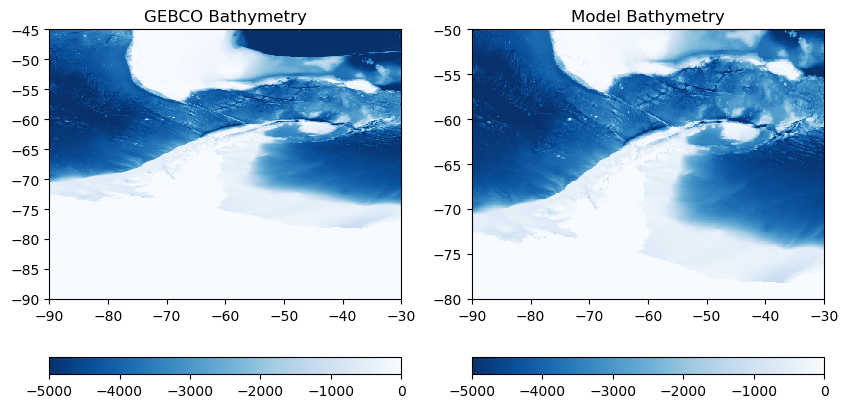

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

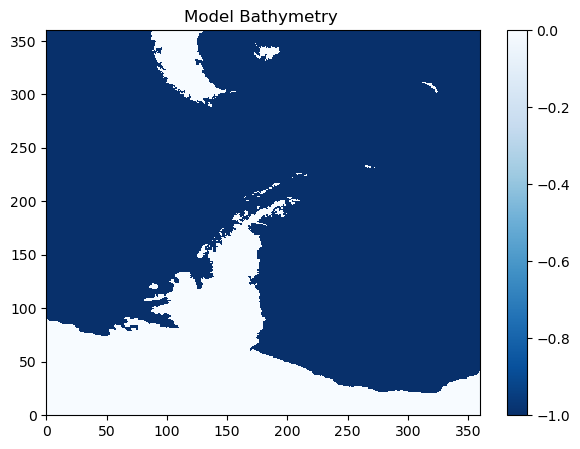

In [62]:
plt.figure(figsize=(7,5))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

As we can see, here is an area of extreme detail on the coast of South America. Before proceeding with the model, this region need to be addressed.

Fortunately, Mike has written a tool to fill in these unconnected regions. You can clone his [eccoseas](https://github.com/mhwood/eccoseas) repository to access a tool related to this process. If you clone it in the current directory, you can use import it here:

In [24]:
from eccoseas.downscale import bathymetry as edb

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [27]:
Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=300, central_wet_col=50)

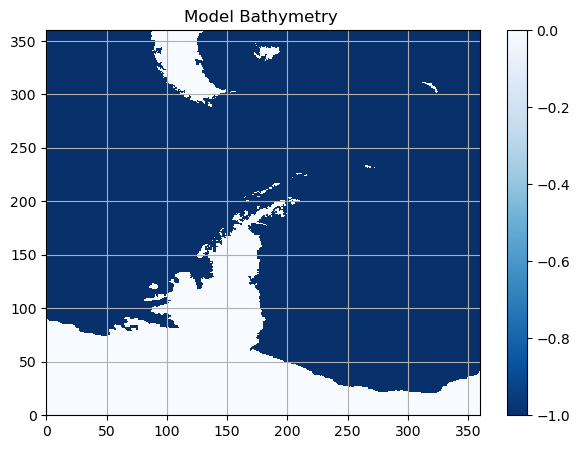

In [61]:
plt.figure(figsize=(7,5))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry ')

plt.show()

### Checking for problem areas
Another potential problem that can be encountered in ocean models occurs in regions where there is shallow bathymetry in enclosed bays. In these regions, there can be fast currents and strong dynamics. If this is your area of interest, then this is great! If not, it may cause problems in your domain. One option is to manually fill in these areas to avoid any potential issues. 

In [63]:
# fill in some areas around BC
Model_bathy_filled = np.copy(Model_bathy)
Model_bathy_filled[75:84, 60:80] = 0


Then, plot the filled bathymetry to ensure it looks as expected

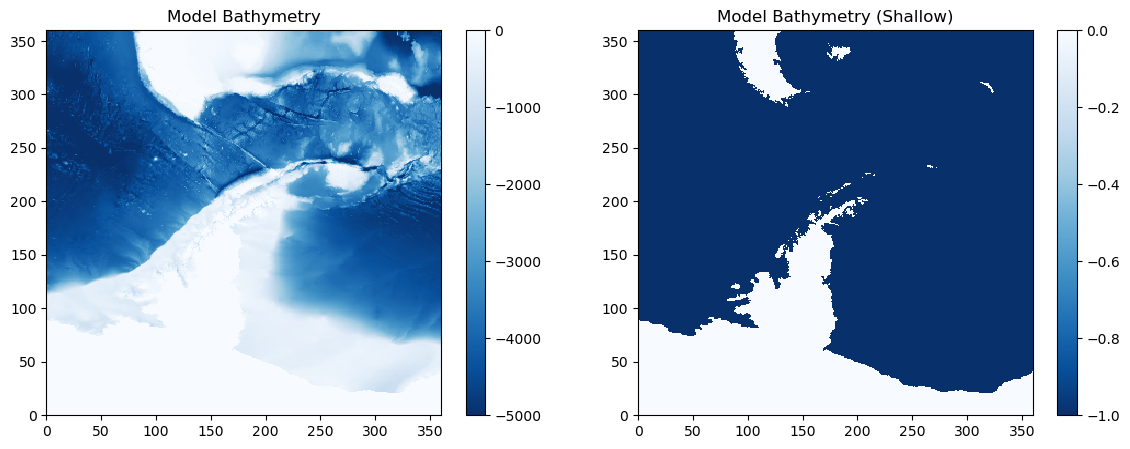

In [64]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')

plt.show()

In [65]:
output_file = 'Antarctica_bathymetry.bin'
Model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'CA_bathymetry.bin,
 &
```